In [1]:
import os, glob, random, json
from dataclasses import dataclass
from typing import List, Tuple

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ----------------------------
# Reproducibility
# ----------------------------
def seed_everything(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 24
seed_everything(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# ----------------------------
# Config
# ----------------------------
@dataclass
class CFG:
    DATA_ROOT: str = "/kaggle/input/sen2fire/Sen2Fire/Sen2Fire"
    SCENES: Tuple[str, ...] = ("scene1", "scene2", "scene3", "scene4")
    PATCH_EXT: str = ".npz"

    # Global split (VD default)
    USE_GLOBAL_SPLIT: bool = True
    GLOBAL_TRAIN_RATIO: float = 0.80
    GLOBAL_VAL_RATIO: float = 0.10
    GLOBAL_TEST_RATIO: float = 0.10
    KEEP_VAL_TEST_NATURAL: bool = True

    # Keys inside npz
    X_KEY: str = "image"     # (12,512,512)
    A_KEY: str = "aerosol"   # (512,512) -> becomes 1 channel
    Y_KEY: str = "label"     # (512,512)

    # Fire patch definition
    FIRE_PATCH_MIN_RATIO: float = 0

    # Controlled train pool (VD default)
    USE_CONTROLLED_POOL: bool = True
    POOL_KEEP_FIRE: int = -1
    NONFIRE_PER_FIRE: int = 3

    # Training config (RAM-safe)
    IN_CHANNELS: int = 13
    H: int = 512
    W: int = 512
    BATCH_SIZE: int = 2
    NUM_WORKERS: int = 2
    LR: float = 1e-4
    EPOCHS: int = 40 

    VERBOSE: bool = True

cfg = CFG()

assert abs((cfg.GLOBAL_TRAIN_RATIO + cfg.GLOBAL_VAL_RATIO + cfg.GLOBAL_TEST_RATIO) - 1.0) < 1e-6
assert os.path.exists(cfg.DATA_ROOT), f"DATA_ROOT not found: {cfg.DATA_ROOT}"
print("DATA_ROOT OK:", cfg.DATA_ROOT)


Device: cuda
DATA_ROOT OK: /kaggle/input/sen2fire/Sen2Fire/Sen2Fire


In [2]:
def list_scene_files(data_root: str, scene_name: str, ext: str = ".npz") -> List[str]:
    scene_dir = os.path.join(data_root, scene_name)
    return sorted(glob.glob(os.path.join(scene_dir, f"*{ext}")))

scene_to_files = {}
total = 0
for s in cfg.SCENES:
    files = list_scene_files(cfg.DATA_ROOT, s, cfg.PATCH_EXT)
    scene_to_files[s] = files
    total += len(files)
    print(f"{s}: {len(files)} patches")

print("Total patches:", total)
if total == 0:
    raise RuntimeError("No patch files found. Check DATA_ROOT / PATCH_EXT.")


scene1: 864 patches
scene2: 594 patches
scene3: 504 patches
scene4: 504 patches
Total patches: 2466


In [3]:
def inspect_npz(npz_path: str):
    with np.load(npz_path) as data:
        return {k: (data[k].shape, str(data[k].dtype)) for k in data.keys()}

sample_path = scene_to_files[cfg.SCENES[0]][0]
print("Sample file:", sample_path)
info = inspect_npz(sample_path)
for k, (shape, dtype) in info.items():
    print(f"  - {k:>10s}: shape={shape}, dtype={dtype}")

for rk in [cfg.X_KEY, cfg.A_KEY, cfg.Y_KEY]:
    if rk not in info:
        raise KeyError(f"Missing key '{rk}' in npz. Found keys: {list(info.keys())}")


Sample file: /kaggle/input/sen2fire/Sen2Fire/Sen2Fire/scene1/scene_1_patch_10_1.npz
  -      image: shape=(12, 512, 512), dtype=int16
  -    aerosol: shape=(512, 512), dtype=float32
  -      label: shape=(512, 512), dtype=uint8


In [4]:
rows = []
for s, files in scene_to_files.items():
    for p in files:
        rows.append({"scene": s, "path": p})
manifest = pd.DataFrame(rows)

def fire_ratio_from_path(npz_path: str) -> float:
    with np.load(npz_path) as data:
        y = data[cfg.Y_KEY]
        if y.ndim == 3 and y.shape[-1] == 1:
            y = y[..., 0]
        yb = (y > 0).astype(np.uint8)
        return float(yb.mean())

fire_ratios = []
has_fire = []
for p in manifest["path"].tolist():
    r = fire_ratio_from_path(p)
    fire_ratios.append(r)
    has_fire.append(1 if r > cfg.FIRE_PATCH_MIN_RATIO else 0)

manifest["fire_ratio"] = fire_ratios
manifest["has_fire"] = has_fire

print("\nFULL dataset has_fire distribution:")
print(manifest["has_fire"].value_counts().sort_index())
print("\nFULL dataset has_fire ratio:")
print(manifest["has_fire"].value_counts(normalize=True).sort_index())



FULL dataset has_fire distribution:
has_fire
0    2117
1     349
Name: count, dtype: int64

FULL dataset has_fire ratio:
has_fire
0    0.858475
1    0.141525
Name: proportion, dtype: float64


In [5]:
with np.load(manifest["path"][0]) as data:
    y = data[cfg.Y_KEY]
    print("y.shape:", y.shape)


y.shape: (512, 512)


In [6]:
import numpy as np

y = np.load(manifest["path"][0])[cfg.Y_KEY]
fire_channel = np.argmax(y.sum(axis=(0,1)))  # channel dengan paling banyak fire
print("Fire channel:", fire_channel)

Fire channel: 0


# DATASET PREPARATION

In [5]:
def stratified_split(df, train_ratio, val_ratio, seed=42):
    df = df.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    parts = []
    for cls in [0, 1]:
        sub = df[df["has_fire"] == cls].copy()
        n = len(sub)
        n_train = int(round(n * train_ratio))
        n_val   = int(round(n * val_ratio))
        sub_train = sub.iloc[:n_train]
        sub_val   = sub.iloc[n_train:n_train+n_val]
        sub_test  = sub.iloc[n_train+n_val:]
        parts.append((sub_train, sub_val, sub_test))

    train_df = pd.concat([parts[0][0], parts[1][0]]).sample(frac=1.0, random_state=seed).reset_index(drop=True)
    val_df   = pd.concat([parts[0][1], parts[1][1]]).sample(frac=1.0, random_state=seed).reset_index(drop=True)
    test_df  = pd.concat([parts[0][2], parts[1][2]]).sample(frac=1.0, random_state=seed).reset_index(drop=True)
    return train_df, val_df, test_df

train_pool_df, val_df, test_df = stratified_split(
    manifest,
    train_ratio=cfg.GLOBAL_TRAIN_RATIO,
    val_ratio=cfg.GLOBAL_VAL_RATIO,
    seed=SEED
)

print("\nGLOBAL split counts:")
print("  Train pool:", len(train_pool_df))
print("  Val      :", len(val_df))
print("  Test     :", len(test_df))

# Controlled pool applies to TRAIN only
if cfg.USE_CONTROLLED_POOL:
    fire_df   = train_pool_df[train_pool_df["has_fire"] == 1].copy()
    nofire_df = train_pool_df[train_pool_df["has_fire"] == 0].copy()

    n_fire_total = len(fire_df)
    n_nofire_total = len(nofire_df)

    n_fire_keep = n_fire_total if cfg.POOL_KEEP_FIRE in (-1, None) else min(cfg.POOL_KEEP_FIRE, n_fire_total)
    fire_keep = fire_df.sample(n=n_fire_keep, random_state=SEED) if n_fire_keep > 0 else fire_df.iloc[:0]

    n_nofire_keep = min(n_nofire_total, n_fire_keep * int(cfg.NONFIRE_PER_FIRE))
    nofire_keep = nofire_df.sample(n=n_nofire_keep, random_state=SEED) if n_nofire_keep > 0 else nofire_df.iloc[:0]

    train_df = pd.concat([fire_keep, nofire_keep]).sample(frac=1.0, random_state=SEED).reset_index(drop=True)

    print("\nTRAIN controlled sampling:")
    print(f"  fire_total_in_pool   : {n_fire_total}")
    print(f"  nofire_total_in_pool : {n_nofire_total}")
    print(f"  fire_kept            : {len(fire_keep)}")
    print(f"  nofire_kept          : {len(nofire_keep)} (NONFIRE_PER_FIRE={cfg.NONFIRE_PER_FIRE})")
    print(f"  train_final          : {len(train_df)}")
else:
    train_df = train_pool_df.copy()

train_paths = train_df["path"].tolist()
val_paths   = val_df["path"].tolist()
test_paths  = test_df["path"].tolist()

# leakage check
assert len(set(train_paths)&set(val_paths))==0
assert len(set(train_paths)&set(test_paths))==0
assert len(set(val_paths)&set(test_paths))==0

print("\nFinal used split sizes:")
print("  train:", len(train_paths))
print("  val  :", len(val_paths))
print("  test :", len(test_paths))



GLOBAL split counts:
  Train pool: 1973
  Val      : 247
  Test     : 246

TRAIN controlled sampling:
  fire_total_in_pool   : 279
  nofire_total_in_pool : 1694
  fire_kept            : 279
  nofire_kept          : 837 (NONFIRE_PER_FIRE=3)
  train_final          : 1116

Final used split sizes:
  train: 1116
  val  : 247
  test : 246


In [6]:
class Sen2FireDataset(Dataset):
    def __init__(self, paths: List[str], with_label: bool = True):
        self.paths = paths
        self.with_label = with_label

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        with np.load(p) as d:
            img12 = d[cfg.X_KEY].astype(np.float32)      # (12,512,512)
            aer   = d[cfg.A_KEY].astype(np.float32)[None, ...]  # (1,512,512)
            x = np.concatenate([img12, aer], axis=0)     # (13,512,512)

            if self.with_label:
                y = d[cfg.Y_KEY]
                if y.ndim == 2:
                    y = y[None, ...]
                y = (y > 0).astype(np.float32)
                return torch.from_numpy(x), torch.from_numpy(y)
            else:
                return torch.from_numpy(x)


In [7]:
train_loader = DataLoader(Sen2FireDataset(train_paths, with_label=True),
                          batch_size=cfg.BATCH_SIZE, shuffle=True,
                          num_workers=cfg.NUM_WORKERS, pin_memory=True)

val_loader = DataLoader(Sen2FireDataset(val_paths, with_label=True),
                        batch_size=cfg.BATCH_SIZE, shuffle=False,
                        num_workers=cfg.NUM_WORKERS, pin_memory=True)

test_loader = DataLoader(Sen2FireDataset(test_paths, with_label=True),
                         batch_size=cfg.BATCH_SIZE, shuffle=False,
                         num_workers=cfg.NUM_WORKERS, pin_memory=True)


In [8]:
@torch.no_grad()
def compute_mean_std(loader, max_batches=50):
    mean = torch.zeros(cfg.IN_CHANNELS, device=DEVICE)
    var  = torch.zeros(cfg.IN_CHANNELS, device=DEVICE)
    n_batches = 0

    for bi, (x, y) in enumerate(loader):
        if bi >= max_batches:
            break
        x = x.to(DEVICE)  # (B,C,H,W)
        x_ = x.view(x.size(0), cfg.IN_CHANNELS, -1)
        mean += x_.mean(dim=(0,2))
        var  += x_.var(dim=(0,2), unbiased=False)
        n_batches += 1

    mean /= max(n_batches, 1)
    var  /= max(n_batches, 1)
    std = torch.sqrt(var + 1e-6)
    return mean.detach().cpu().tolist(), std.detach().cpu().tolist()

MEAN_13, STD_13 = compute_mean_std(train_loader, max_batches=50)
print("MEAN_13 len:", len(MEAN_13), "STD_13 len:", len(STD_13))


MEAN_13 len: 13 STD_13 len: 13


# MODEL PREPARATION


In [9]:
!pip -q install segmentation-models-pytorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.8 MB/s eta 0:00:0000:01


In [10]:
def normalize_batch(x, mean_13, std_13):
    mean_t = torch.tensor(mean_13, device=x.device).view(1, cfg.IN_CHANNELS, 1, 1)
    std_t  = torch.tensor(std_13,  device=x.device).view(1, cfg.IN_CHANNELS, 1, 1)
    return (x - mean_t) / (std_t + 1e-6)

In [11]:
import segmentation_models_pytorch as smp

criterion = nn.BCEWithLogitsLoss()
def build_unet(in_channels=13):
    model = smp.Unet(
        encoder_name="resnet18",
        encoder_weights="imagenet",
        in_channels=in_channels,
        classes=1,
        activation=None
    )
    return model
    
model = build_unet(cfg.IN_CHANNELS).to(DEVICE)
print("Model:", type(model).__name__)

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Model: Unet


In [21]:
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import roc_auc_score
import time

optimizer = torch.optim.Adam(model.parameters(), lr=cfg.LR)
scaler = GradScaler(enabled=(DEVICE.type == "cuda"))

def train_one_epoch(model, loader, thr=0.5, eps=1e-6):
    model.train()
    total_loss_sum = 0.0
    total_samples = 0

    total_tp = total_fp = total_fn = total_tn = 0.0
    all_probs, all_targets = [], []

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        x = normalize_batch(x, MEAN_13, STD_13)

        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=(DEVICE.type == "cuda")):
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bs = x.size(0)
        total_loss_sum += loss.item() * bs
        total_samples += bs

        probs = torch.sigmoid(logits)
        preds = (probs >= thr).float()

        total_tp += (preds * y).sum().item()
        total_fp += (preds * (1 - y)).sum().item()
        total_fn += ((1 - preds) * y).sum().item()
        total_tn += ((1 - preds) * (1 - y)).sum().item()

        all_probs.append(probs.flatten().detach().cpu())
        all_targets.append(y.flatten().detach().cpu())

    precision = (total_tp + eps) / (total_tp + total_fp + eps)
    recall    = (total_tp + eps) / (total_tp + total_fn + eps)
    f1        = (2 * precision * recall) / (precision + recall + eps)
    acc       = (total_tp + total_tn + eps) / (
        total_tp + total_tn + total_fp + total_fn + eps
    )

    all_probs = torch.cat(all_probs).numpy()
    all_targets = torch.cat(all_targets).numpy()
    auc = roc_auc_score(all_targets, all_probs)

    loss_global = total_loss_sum / total_samples

    return loss_global, precision, recall, f1, acc, auc


@torch.no_grad()
def validate_epoch(model, loader, thr=0.5, eps=1e-6):
    model.eval()
    total_loss_sum = 0.0
    total_samples = 0

    total_tp = total_fp = total_fn = total_tn = 0.0
    all_probs, all_targets = [], []

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        x = normalize_batch(x, MEAN_13, STD_13)

        logits = model(x)
        loss = criterion(logits, y)

        bs = x.size(0)
        total_loss_sum += loss.item() * bs
        total_samples += bs

        probs = torch.sigmoid(logits)
        preds = (probs >= thr).float()

        total_tp += (preds * y).sum().item()
        total_fp += (preds * (1 - y)).sum().item()
        total_fn += ((1 - preds) * y).sum().item()
        total_tn += ((1 - preds) * (1 - y)).sum().item()

        all_probs.append(probs.flatten().cpu())
        all_targets.append(y.flatten().cpu())

    precision = (total_tp + eps) / (total_tp + total_fp + eps)
    recall    = (total_tp + eps) / (total_tp + total_fn + eps)
    f1        = (2 * precision * recall) / (precision + recall + eps)
    acc       = (total_tp + total_tn + eps) / (
        total_tp + total_tn + total_fp + total_fn + eps
    )

    all_probs = torch.cat(all_probs).numpy()
    all_targets = torch.cat(all_targets).numpy()
    auc = roc_auc_score(all_targets, all_probs)

    loss_global = total_loss_sum / total_samples

    return loss_global, precision, recall, f1, acc, auc


/tmp/ipykernel_55/735404605.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(DEVICE.type == "cuda"))


In [17]:
x_tr, _ = next(iter(train_loader))
x_va, _ = next(iter(val_loader))

x_tr = normalize_batch(x_tr.to(DEVICE), MEAN_13, STD_13)
x_va = normalize_batch(x_va.to(DEVICE), MEAN_13, STD_13)

print("train norm min/max:", x_tr.min().item(), x_tr.max().item())
print("val   norm min/max:", x_va.min().item(), x_va.max().item())

train norm min/max: -3.318262815475464 16.394107818603516
val   norm min/max: -4.052846431732178 6.270531177520752


# TRAINING

In [23]:
BEST_PATH = "/kaggle/working/unet_best.pth"
best_val_f1 = -1

import pandas as pd
history = []

for epoch in range(1, cfg.EPOCHS + 1):
    t0 = time.time()

    tr_loss, tr_prec, tr_rec, tr_f1, tr_acc, tr_auc = train_one_epoch(model, train_loader)
    va_loss, va_prec, va_rec, va_f1, va_acc, va_auc = validate_epoch(model, val_loader, thr=0.5)
    elapsed = time.time() - t0

    print(
        f"[unet_basic] Epoch {epoch:03d} | "
        f"tr_loss={tr_loss:.4f} tr_f1={tr_f1:.4f} tr_acc={tr_acc:.4f} tr_auc={tr_auc:.4f} || "
        f"va_loss={va_loss:.4f} va_f1={va_f1:.4f} va_acc={va_acc:.4f} va_auc={va_auc:.4f} | "
        f"{elapsed:.1f}s"
    )

    history.append({
        "epoch": epoch,
    
        "tr_loss": tr_loss,
        "tr_precision": tr_prec,
        "tr_recall": tr_rec,
        "tr_f1": tr_f1,
        "tr_acc": tr_acc,
        "tr_auc": tr_auc,
    
        "va_loss": va_loss,
        "va_precision": va_prec,
        "va_recall": va_rec,
        "va_f1": va_f1,
        "va_acc": va_acc,
        "va_auc": va_auc,
    
        "seconds": elapsed
    })

    if va_f1 > best_val_f1:
        torch.save({
            "model_state": model.state_dict(),
            "mean_13": MEAN_13,
            "std_13": STD_13,
            "thr": thr,
            "epoch": epoch,
            "best_val_f1": best_val_f1,
            "va_auc": va_auc,
            "model_name": model_name
        }, BEST_PATH)


/tmp/ipykernel_55/735404605.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == "cuda")):


[unet_basic] Epoch 001 | tr_loss=0.2158 tr_f1=0.0234 tr_acc=0.9411 tr_auc=0.7017 || va_loss=0.1627 va_f1=0.0007 va_acc=0.9522 va_auc=0.8390 | 198.8s


/tmp/ipykernel_55/735404605.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == "cuda")):


[unet_basic] Epoch 002 | tr_loss=0.2008 tr_f1=0.0241 tr_acc=0.9411 tr_auc=0.6884 || va_loss=0.1650 va_f1=0.0468 va_acc=0.9530 va_auc=0.7855 | 195.5s


/tmp/ipykernel_55/735404605.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == "cuda")):


[unet_basic] Epoch 003 | tr_loss=0.1884 tr_f1=0.0207 tr_acc=0.9410 tr_auc=0.7671 || va_loss=0.1480 va_f1=0.1404 va_acc=0.9546 va_auc=0.8509 | 192.3s


/tmp/ipykernel_55/735404605.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == "cuda")):


[unet_basic] Epoch 004 | tr_loss=0.1851 tr_f1=0.1225 tr_acc=0.9419 tr_auc=0.7681 || va_loss=0.1444 va_f1=0.1438 va_acc=0.9547 va_auc=0.8699 | 187.6s


/tmp/ipykernel_55/735404605.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == "cuda")):


[unet_basic] Epoch 005 | tr_loss=0.1787 tr_f1=0.2314 tr_acc=0.9437 tr_auc=0.7872 || va_loss=0.1605 va_f1=0.0214 va_acc=0.9525 va_auc=0.8287 | 187.1s


/tmp/ipykernel_55/735404605.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == "cuda")):


[unet_basic] Epoch 006 | tr_loss=0.1752 tr_f1=0.2767 tr_acc=0.9436 tr_auc=0.8052 || va_loss=0.1584 va_f1=0.0000 va_acc=0.9522 va_auc=0.8290 | 195.6s


/tmp/ipykernel_55/735404605.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == "cuda")):


[unet_basic] Epoch 007 | tr_loss=0.1756 tr_f1=0.2651 tr_acc=0.9430 tr_auc=0.7977 || va_loss=0.1667 va_f1=0.0000 va_acc=0.9522 va_auc=0.7991 | 194.4s


/tmp/ipykernel_55/735404605.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == "cuda")):


[unet_basic] Epoch 008 | tr_loss=0.1735 tr_f1=0.2695 tr_acc=0.9437 tr_auc=0.8178 || va_loss=0.1469 va_f1=0.1335 va_acc=0.9543 va_auc=0.8729 | 194.8s


/tmp/ipykernel_55/735404605.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == "cuda")):


[unet_basic] Epoch 009 | tr_loss=0.1707 tr_f1=0.2865 tr_acc=0.9449 tr_auc=0.8161 || va_loss=0.1573 va_f1=0.0000 va_acc=0.9522 va_auc=0.8554 | 189.7s


/tmp/ipykernel_55/735404605.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == "cuda")):


[unet_basic] Epoch 010 | tr_loss=0.1685 tr_f1=0.3602 tr_acc=0.9463 tr_auc=0.8220 || va_loss=0.1472 va_f1=0.1832 va_acc=0.9549 va_auc=0.8600 | 189.6s


/tmp/ipykernel_55/735404605.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == "cuda")):


[unet_basic] Epoch 011 | tr_loss=0.1649 tr_f1=0.3347 tr_acc=0.9458 tr_auc=0.8312 || va_loss=0.1505 va_f1=0.0550 va_acc=0.9531 va_auc=0.8533 | 191.4s


/tmp/ipykernel_55/735404605.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == "cuda")):


[unet_basic] Epoch 012 | tr_loss=0.1681 tr_f1=0.3607 tr_acc=0.9470 tr_auc=0.8157 || va_loss=0.1489 va_f1=0.0000 va_acc=0.9522 va_auc=0.8641 | 191.8s


/tmp/ipykernel_55/735404605.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == "cuda")):


[unet_basic] Epoch 013 | tr_loss=0.1652 tr_f1=0.3453 tr_acc=0.9458 tr_auc=0.8426 || va_loss=0.1415 va_f1=0.1635 va_acc=0.9545 va_auc=0.8671 | 195.2s


/tmp/ipykernel_55/735404605.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == "cuda")):


[unet_basic] Epoch 014 | tr_loss=0.1628 tr_f1=0.3625 tr_acc=0.9462 tr_auc=0.8417 || va_loss=0.1614 va_f1=0.0000 va_acc=0.9522 va_auc=0.8598 | 192.5s


/tmp/ipykernel_55/735404605.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == "cuda")):


[unet_basic] Epoch 015 | tr_loss=0.1756 tr_f1=0.2703 tr_acc=0.9443 tr_auc=0.8111 || va_loss=0.2844 va_f1=0.0000 va_acc=0.9522 va_auc=0.5947 | 194.8s


/tmp/ipykernel_55/735404605.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == "cuda")):


[unet_basic] Epoch 016 | tr_loss=0.1684 tr_f1=0.2927 tr_acc=0.9465 tr_auc=0.8270 || va_loss=0.1428 va_f1=0.1002 va_acc=0.9537 va_auc=0.8595 | 193.8s


/tmp/ipykernel_55/735404605.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == "cuda")):


[unet_basic] Epoch 017 | tr_loss=0.1602 tr_f1=0.3762 tr_acc=0.9472 tr_auc=0.8480 || va_loss=0.1379 va_f1=0.2023 va_acc=0.9556 va_auc=0.8790 | 194.1s


/tmp/ipykernel_55/735404605.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == "cuda")):


[unet_basic] Epoch 018 | tr_loss=0.1484 tr_f1=0.4399 tr_acc=0.9500 tr_auc=0.8739 || va_loss=0.1444 va_f1=0.4110 va_acc=0.9599 va_auc=0.8884 | 190.3s


/tmp/ipykernel_55/735404605.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == "cuda")):


[unet_basic] Epoch 019 | tr_loss=0.1477 tr_f1=0.4413 tr_acc=0.9489 tr_auc=0.8770 || va_loss=0.1427 va_f1=0.2610 va_acc=0.9564 va_auc=0.8880 | 193.1s


/tmp/ipykernel_55/735404605.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == "cuda")):


[unet_basic] Epoch 020 | tr_loss=0.1380 tr_f1=0.4970 tr_acc=0.9531 tr_auc=0.8877 || va_loss=0.1479 va_f1=0.0000 va_acc=0.9522 va_auc=0.8732 | 192.7s


In [25]:
df_history = pd.DataFrame(history)

df_history = df_history.round(4)
csv_path = "/kaggle/working/training_metrics1.csv"
df_history.to_csv(csv_path, index=False)
print("Saved to:", csv_path)
df_history


,epoch,tr_loss,tr_precision,tr_recall,tr_f1,tr_acc,tr_auc,va_loss,va_precision,va_recall,va_f1,va_acc,va_auc,seconds
0,1,0.2158,0.5144,0.0120,0.0234,0.9411,0.7017,0.1627,0.6629,0.0004,0.0007,0.9522,0.8390,198.7840
1,2,0.2008,0.4886,0.0124,0.0241,0.9411,0.6884,0.1650,0.7561,0.0241,0.0468,0.9530,0.7855,195.5212
2,3,0.1884,0.4473,0.0106,0.0207,0.9410,0.7671,0.1480,0.7419,0.0775,0.1404,0.9546,0.8509,192.3430
3,4,0.1851,0.5523,0.0689,0.1225,0.9419,0.7681,0.1444,0.7418,0.0796,0.1438,0.9547,0.8699,187.6002
4,5,0.1787,0.5891,0.1440,0.2314,0.9437,0.7872,0.1605,0.7568,0.0109,0.0214,0.9525,0.8287,187.1016
5,6,0.1752,0.5649,0.1832,0.2767,0.9436,0.8052,0.1584,1.0000,0.0000,0.0000,0.9522,0.8290,195.6284
6,7,0.1756,0.5516,0.1745,0.2651,0.9430,0.7977,0.1667,1.0000,0.0000,0.0000,0.9522,0.7991,194.3773
7,8,0.1735,0.5704,0.1764,0.2695,0.9437,0.8178,0.1469,0.7227,0.0735,0.1335,0.9543,0.8729,194.8437
8,9,0.1707,0.6034,0.1878,0.2865,0.9449,0.8161,0.1573,1.0000,0.0000,0.0000,0.9522,0.8554,189.7026
9,10,0.1685,0.6035,0.2568,0.3602,0.9463,0.8220,0.1472,0.6880,0.1057,0.1832,0.9549,0.8600,189.6036


# SETTING THRESHOLD & PREDICTING VAL_TEST SET

In [31]:
@torch.no_grad()
def find_best_thr_global_f1(model, loader, grid=None, eps=1e-6):
    model.eval()
    if grid is None:
        grid = np.linspace(0.05, 0.95, 19)

    best_thr = None
    best_f1 = -1
    log = []

    for thr in grid:
        total_tp = total_fp = total_fn = 0.0

        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            x = normalize_batch(x, MEAN_13, STD_13)

            logits = model(x)
            probs = torch.sigmoid(logits)
            preds = (probs >= thr).float()

            total_tp += (preds * y).sum().item()
            total_fp += (preds * (1 - y)).sum().item()
            total_fn += ((1 - preds) * y).sum().item()

        precision = (total_tp + eps) / (total_tp + total_fp + eps)
        recall    = (total_tp + eps) / (total_tp + total_fn + eps)
        f1        = (2 * precision * recall) / (precision + recall + eps)

        log.append((float(thr), f1))

        if f1 > best_f1:
            best_f1 = f1
            best_thr = float(thr)

    return best_thr, best_f1, log

t_best, best_f1, thr_log = find_best_thr_global_f1(model, val_loader)

print("Chosen threshold:", t_best)
print("Best global F1:", best_f1)

print("Top-5 thresholds:")
for thr, f1 in sorted(thr_log, key=lambda x: x[1], reverse=True)[:5]:
    print(thr, f1)

Chosen threshold: 0.15
Best global F1: 0.4531659705675882
Top-5 thresholds:
0.15 0.4531659705675882
0.1 0.4306327801299006
0.2 0.31735838172380243
0.05 0.2870529543492742
0.25 0.0921978563493968


In [42]:
va_loss, va_prec, va_rec, va_f1, va_acc, va_auc = validate_epoch(
    model, val_loader, thr=t_best
)
print(f"val_loss   : {va_loss:.4f}")
print(f"val_prec   : {va_prec:.4f}")
print(f"val_recall : {va_rec:.4f}")
print(f"val_f1     : {va_f1:.4f}")
print(f"val_acc    : {va_acc:.4f}")
print(f"val_auc    : {va_auc:.4f}")
print(f"threshold  : {t_best:.2f}")

val_loss   : 0.1479
val_prec   : 0.5960
val_recall : 0.3655
val_f1     : 0.4532
val_acc    : 0.9578
val_auc    : 0.8732
threshold  : 0.15


In [36]:
# sweet spot refine
sweet_grid = np.linspace(0.10, 0.20, 11)  # step 0.01
t_best, best_f1, thr_log = find_best_thr_global_f1(model, val_loader,  grid=sweet_grid)
print("Chosen threshold:", t_best)
print("Best global F1:", best_f1)

Chosen threshold: 0.13
Best global F1: 0.45931266084982436


bener ini harusny metric nya AUC bukan F1-score, selisih dari 0.1 sampe 0.5 drastis bgt, ini kebetulan didapat f1 tertingginy sama dengan AUC tertinggi

In [39]:
va_loss, va_prec, va_rec, va_f1, va_acc, va_auc = validate_epoch(
    model, val_loader, thr=t_best
)
print(f"val_loss   : {va_loss:.4f}")
print(f"val_prec   : {va_prec:.4f}")
print(f"val_recall : {va_rec:.4f}")
print(f"val_f1     : {va_f1:.4f}")
print(f"val_acc    : {va_acc:.4f}")
print(f"val_auc    : {va_auc:.4f}")
print(f"threshold  : {t_best:.2f}")

val_loss   : 0.1479
val_prec   : 0.5068
val_recall : 0.4199
val_f1     : 0.4593
val_acc    : 0.9527
val_auc    : 0.8732
threshold  : 0.13


In [30]:
# pake t_high 0.45 0.85 auc LU

# print(f"val_loss   : {va_loss:.4f}")
# print(f"val_prec   : {va_prec:.4f}")
# print(f"val_recall : {va_rec:.4f}")
# print(f"val_f1     : {va_f1:.4f}")
# print(f"val_acc    : {va_acc:.4f}")
# print(f"val_auc    : {va_auc:.4f}")
# print(f"threshold  : {t_high:.2f}")

val_loss   : 0.1479
val_prec   : 0.5132
val_recall : 0.0001
val_f1     : 0.0002
val_acc    : 0.9522
val_auc    : 0.8732
threshold  : 0.45


In [45]:
test_loss, test_prec, test_rec, test_f1, test_acc, test_auc = validate_epoch(
    model, test_loader, thr=t_best
)

print(f"Test Loss   : {test_loss:.4f}")
print(f"Test Prec   : {test_prec:.4f}")
print(f"Test Recall : {test_rec:.4f}")
print(f"Test F1     : {test_f1:.4f}")
print(f"Test Acc    : {test_acc:.4f}")
print(f"Test AUC    : {test_auc:.4f}")

Test Loss   : 0.0958
Test Prec   : 0.2929
Test Recall : 0.3537
Test F1     : 0.3204
Test Acc    : 0.9636
Test AUC    : 0.8443


In [53]:
torch.save({
    "model_state": model.state_dict(),
    "mean_13": MEAN_13,
    "std_13": STD_13,
    "threshold": t_best
}, BEST_PATH)

In [52]:
import numpy as np

path = manifest["path"][0]
with np.load(path) as data:
    y = data[cfg.Y_KEY]
    print("y.shape:", y.shape)


y.shape: (512, 512)


In [55]:
print(x[0, :3, :, :].min(), x[0, :3, :, :].max())

tensor(679., device='cuda:0') tensor(1854., device='cuda:0')


In [56]:
img_vis = img[..., :3]  # tanpa de-normalize dulu
img_vis = (img_vis - img_vis.min()) / (img_vis.max() - img_vis.min())
img_vis

array([[[0.09361702, 0.09021276, 0.07489362],
        [0.09361702, 0.11489362, 0.10553192],
        [0.09361702, 0.09021276, 0.07489362],
        ...,
        [0.31914893, 0.42468086, 0.47914892],
        [0.37106383, 0.44170213, 0.4944681 ],
        [0.37106383, 0.44      , 0.47234043]],

       [[0.09361702, 0.08340426, 0.0706383 ],
        [0.09361702, 0.10893617, 0.07489362],
        [0.09361702, 0.08680851, 0.06893617],
        ...,
        [0.31914893, 0.42978725, 0.48595744],
        [0.37106383, 0.44170213, 0.4944681 ],
        [0.37106383, 0.44      , 0.48595744]],

       [[0.09361702, 0.11148936, 0.10978723],
        [0.09361702, 0.11914894, 0.10042553],
        [0.09361702, 0.10212766, 0.09446809],
        ...,
        [0.31914893, 0.42978725, 0.49617022],
        [0.37106383, 0.44170213, 0.5046809 ],
        [0.37106383, 0.42808512, 0.5046809 ]],

       ...,

       [[0.28      , 0.23914893, 0.1906383 ],
        [0.28      , 0.23148936, 0.17617022],
        [0.28      , 0

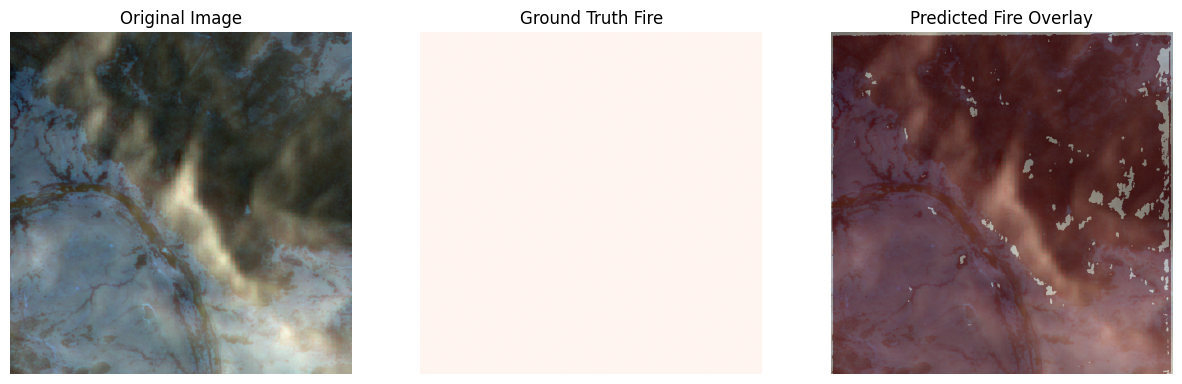

In [57]:
img = x[0].cpu().permute(1,2,0).numpy()[..., :3]  # ambil 3 channel pertama
img_vis = (img - img.min()) / (img.max() - img.min())  # scale 0-1

gt_fire = y[0, 0].cpu().numpy()  # fire channel
with torch.no_grad():
    logits = model(x)
    probs = torch.sigmoid(logits)
    pred_fire = (probs[0, 0] >= t_best).cpu().numpy()

fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(img_vis)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(gt_fire, cmap='Reds')
axes[1].set_title("Ground Truth Fire")
axes[1].axis('off')

axes[2].imshow(img_vis)
axes[2].imshow(pred_fire, cmap='Reds', alpha=0.4)
axes[2].set_title("Predicted Fire Overlay")
axes[2].axis('off')

plt.show()


In [101]:
@torch.no_grad()
def fire_area_preview_with_samples(model, loader, t_best, eps_area=1e-3, a1=0.15, a2=0.3):
    model.eval()
    buckets = {
        "NO_FIRE": [],
        "LOW_FIRE": [],
        "MID_FIRE": [],
        "HIGH_FIRE": [],
    }

    # kumpulin sample dulu
    for x, y in loader:
        x = x.to(DEVICE)
        x = normalize_batch(x, MEAN_13, STD_13)

        probs = torch.sigmoid(model(x))  # (B,C,H,W)
        mask = (probs >= t_best).float()
        area = mask.mean(dim=(1, 2, 3))  # rata-rata per sample

        for i in range(len(area)):
            sample_dict = {
                "img": x[i].cpu(),
                "mask_pred": mask[i,0].cpu(), 
                "mask_gt": y[i,0].cpu(),
                "area": float(area[i])
            }
            if area[i] < eps_area:
                buckets["NO_FIRE"].append(sample_dict)
            elif area[i] < a1:
                buckets["LOW_FIRE"].append(sample_dict)
            elif area[i] < a2:
                buckets["MID_FIRE"].append(sample_dict)
            else:
                buckets["HIGH_FIRE"].append(sample_dict)

    # print & return supaya bisa dipakai buat overlay
    print("=== FIRE AREA PREVIEW ===")
    for k, samples in buckets.items():
        if len(samples) == 0:
            print(f"[{k}] kosong")
            continue

        areas = np.array([s["area"] for s in samples])
        print(f"[{k}] count={len(samples)} | mean_area={areas.mean():.4f}")
        picks = np.random.choice(len(samples), min(5, len(samples)), replace=False)
        for idx in picks:
            print(f"  sample → Area={areas[idx]:.4f}")

    return buckets  # simpan semua sample per kategori

In [103]:
test_buckets = fire_area_preview_with_samples(model, test_loader, t_best)

=== FIRE AREA PREVIEW ===
[NO_FIRE] count=143 | mean_area=0.0001
  sample → Area=0.0000
  sample → Area=0.0001
  sample → Area=0.0000
  sample → Area=0.0001
  sample → Area=0.0000
[LOW_FIRE] count=89 | mean_area=0.0228
  sample → Area=0.0930
  sample → Area=0.0036
  sample → Area=0.0025
  sample → Area=0.0089
  sample → Area=0.0923
[MID_FIRE] count=4 | mean_area=0.2418
  sample → Area=0.2505
  sample → Area=0.2607
  sample → Area=0.1873
  sample → Area=0.2685
[HIGH_FIRE] count=10 | mean_area=0.4201
  sample → Area=0.5472
  sample → Area=0.5505
  sample → Area=0.3540
  sample → Area=0.3122
  sample → Area=0.3548


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

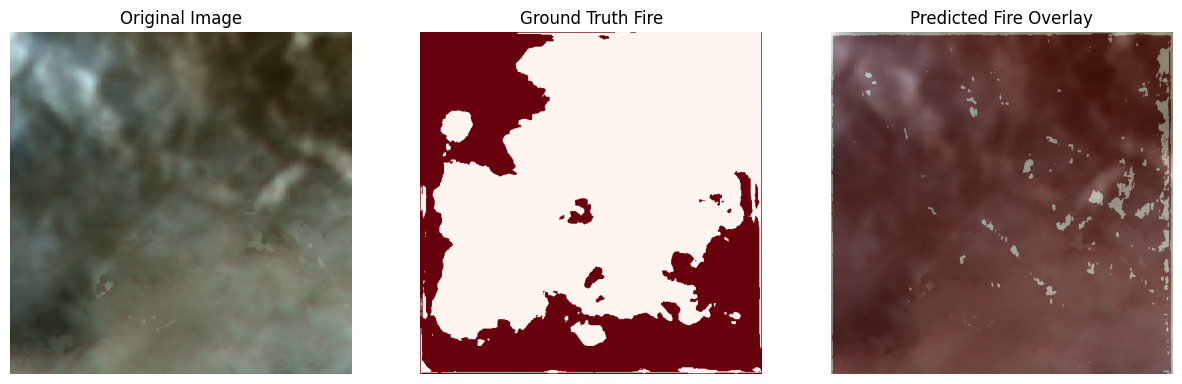

In [89]:
sample = buckets["HIGH_FIRE"][0]
img_vis = sample["img"].permute(1,2,0).numpy()  # HWC
mask = sample["mask"].numpy()

plt.imshow(img_vis[..., :3])  # RGB
plt.imshow(mask, cmap='Reds', alpha=0.4)
plt.show()

img = sample["img"].cpu().permute(1,2,0).numpy()[..., :3]  # ambil 3 channel pertama
img_vis = (img - img.min()) / (img.max() - img.min())  # scale 0-1

mask = sample["mask"].numpy()
with torch.no_grad():
    logits = model(x)
    probs = torch.sigmoid(logits)
    pred_fire = (probs[0, 0] >= t_best).cpu().numpy()

fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(img_vis)
axes[0].set_title(f"Original Image\nArea={area_val:.4f}")
axes[0].axis('off')

axes[1].imshow(mask, cmap='Reds')
axes[1].set_title("Ground Truth Fire")
axes[1].axis('off')

axes[2].imshow(img_vis)
axes[2].imshow(pred_fire, cmap='Reds', alpha=0.4)
axes[2].set_title("Predicted Fire Overlay")
axes[2].axis('off')

In [108]:
@torch.no_grad()
def check_ground_truth_metadata(loader):
    # Ambil 1 batch saja untuk pengecekan
    x, y = next(iter(loader))
    
    print("=== METADATA CHECK ===")
    print(f"Shape Image (x) : {x.shape}") # Harusnya [B, C, 512, 512]
    print(f"Shape Label (y) : {y.shape}") # Harusnya [B, 1, 512, 512]
    
    # Cek nilai unik di label
    # Jika isinya cuma 0.0 dan 1.0 tapi bentuknya kotak, 
    # berarti y memang hasil 'upscale' paksa dari resolusi rendah.
    unique_vals = torch.unique(y)
    print(f"Unique values in y: {unique_vals}")
    
    # Cek apakah y punya dimensi yang sama dengan x
    if x.shape[2:] == y.shape[2:]:
        print("✅ Ukuran H x W sudah sama.")
    else:
        print("❌ Ukuran H x W berbeda! Ini penyebab error atau visualisasi aneh.")

    # Cek statistik nilai
    print(f"Y Max: {y.max().item()} | Y Min: {y.min().item()} | Y Mean: {y.mean().item():.6f}")
    
    # Opsional: Cek ukuran asli dari satu sample sebelum diproses (jika ada di dataset)
    # print(f"Raw Label Resolution: {y[0].cpu().numpy().nonzero()}")

# Panggil fungsinya
check_ground_truth_metadata(train_loader)

=== METADATA CHECK ===
Shape Image (x) : torch.Size([2, 13, 512, 512])
Shape Label (y) : torch.Size([2, 1, 512, 512])
Unique values in y: tensor([0., 1.])
✅ Ukuran H x W sudah sama.
Y Max: 1.0 | Y Min: 0.0 | Y Mean: 0.037388


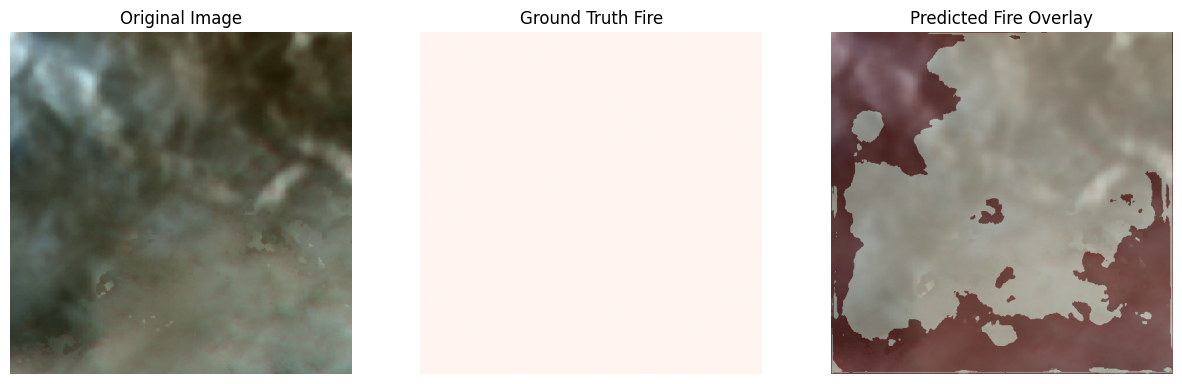

In [104]:
sample = test_buckets["HIGH_FIRE"][0]
img_vis = sample["img"].permute(1,2,0).numpy()[..., :3]
img_vis = (img_vis - img_vis.min()) / (img_vis.max() - img_vis.min())

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img_vis)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(sample["mask_gt"], cmap='Reds')
plt.title("Ground Truth Fire")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img_vis)
plt.imshow(sample["mask_pred"], cmap='Reds', alpha=0.4)
plt.title("Predicted Fire Overlay")
plt.axis('off')

plt.show()


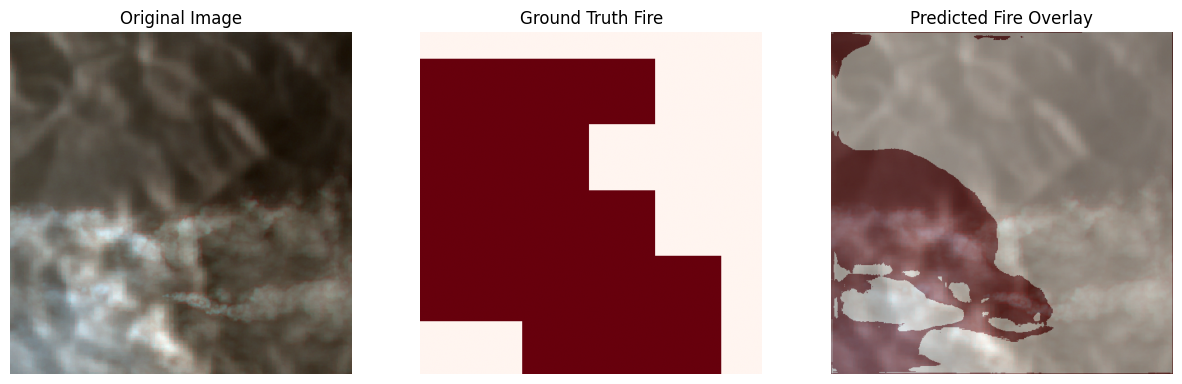

In [106]:
sample = test_buckets["MID_FIRE"][0]
img_vis = sample["img"].permute(1,2,0).numpy()[..., :3]
img_vis = (img_vis - img_vis.min()) / (img_vis.max() - img_vis.min())

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img_vis)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(sample["mask_gt"], cmap='Reds')
plt.title("Ground Truth Fire")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img_vis)
plt.imshow(sample["mask_pred"], cmap='Reds', alpha=0.4)
plt.title("Predicted Fire Overlay")
plt.axis('off')

plt.show()


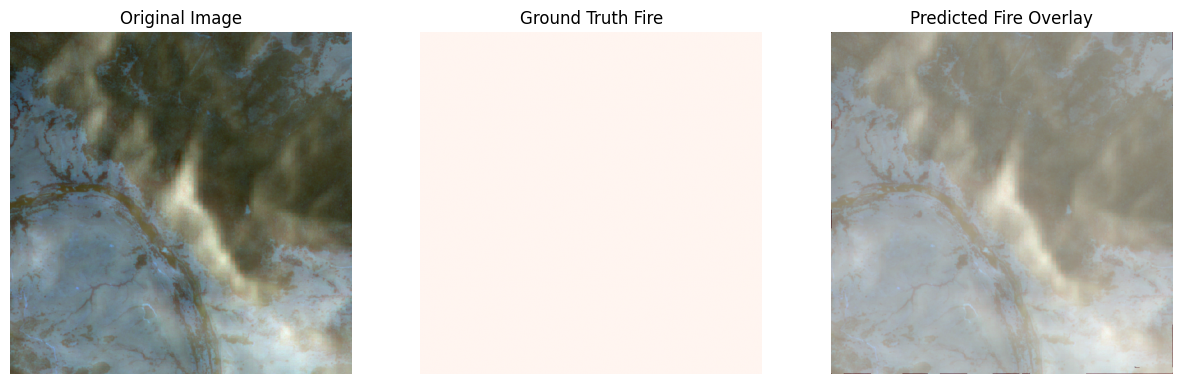

In [107]:
sample = test_buckets["LOW_FIRE"][0]
img_vis = sample["img"].permute(1,2,0).numpy()[..., :3]
img_vis = (img_vis - img_vis.min()) / (img_vis.max() - img_vis.min())

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img_vis)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(sample["mask_gt"], cmap='Reds')
plt.title("Ground Truth Fire")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img_vis)
plt.imshow(sample["mask_pred"], cmap='Reds', alpha=0.4)
plt.title("Predicted Fire Overlay")
plt.axis('off')

plt.show()


# RECALL MODEL

In [12]:
model = build_unet(cfg.IN_CHANNELS).to(DEVICE)
ckpt = torch.load(
    "/kaggle/input/unet-best2/pytorch/default/1/unet_best.pth",
    map_location=DEVICE
)
model.load_state_dict(ckpt["model_state"])

<All keys matched successfully>

In [16]:
from torch.amp import autocast, GradScaler
from sklearn.metrics import roc_auc_score
import time

optimizer = torch.optim.Adam(model.parameters(), lr=cfg.LR)
scaler = GradScaler(enabled=(DEVICE.type == "cuda"))

def train_one_epoch(model, loader, thr=0.13, eps=1e-6):
    model.train()
    total_loss_sum = 0.0
    total_samples = 0

    total_tp = total_fp = total_fn = total_tn = 0.0
    all_probs, all_targets = [], []

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        x = normalize_batch(x, MEAN_13, STD_13)

        optimizer.zero_grad(set_to_none=True)

        with autocast("cuda", enabled=(DEVICE.type == "cuda")):
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bs = x.size(0)
        total_loss_sum += loss.item() * bs
        total_samples += bs

        probs = torch.sigmoid(logits)
        preds = (probs >= thr).float()

        total_tp += (preds * y).sum().item()
        total_fp += (preds * (1 - y)).sum().item()
        total_fn += ((1 - preds) * y).sum().item()
        total_tn += ((1 - preds) * (1 - y)).sum().item()

        all_probs.append(probs.flatten().detach().cpu())
        all_targets.append(y.flatten().detach().cpu())

    precision = (total_tp + eps) / (total_tp + total_fp + eps)
    recall    = (total_tp + eps) / (total_tp + total_fn + eps)
    f1        = (2 * precision * recall) / (precision + recall + eps)
    acc       = (total_tp + total_tn + eps) / (
        total_tp + total_tn + total_fp + total_fn + eps
    )

    all_probs = torch.cat(all_probs).numpy()
    all_targets = torch.cat(all_targets).numpy()
    auc = roc_auc_score(all_targets, all_probs)

    loss_global = total_loss_sum / total_samples

    return loss_global, precision, recall, f1, acc, auc


@torch.no_grad()
def validate_epoch(model, loader, thr=0.13, eps=1e-6):
    model.eval()
    total_loss_sum = 0.0
    total_samples = 0

    total_tp = total_fp = total_fn = total_tn = 0.0
    all_probs, all_targets = [], []

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        x = normalize_batch(x, MEAN_13, STD_13)

        logits = model(x)
        loss = criterion(logits, y)

        bs = x.size(0)
        total_loss_sum += loss.item() * bs
        total_samples += bs

        probs = torch.sigmoid(logits)
        preds = (probs >= thr).float()

        total_tp += (preds * y).sum().item()
        total_fp += (preds * (1 - y)).sum().item()
        total_fn += ((1 - preds) * y).sum().item()
        total_tn += ((1 - preds) * (1 - y)).sum().item()

        all_probs.append(probs.flatten().cpu())
        all_targets.append(y.flatten().cpu())

    precision = (total_tp + eps) / (total_tp + total_fp + eps)
    recall    = (total_tp + eps) / (total_tp + total_fn + eps)
    f1        = (2 * precision * recall) / (precision + recall + eps)
    acc       = (total_tp + total_tn + eps) / (
        total_tp + total_tn + total_fp + total_fn + eps
    )

    all_probs = torch.cat(all_probs).numpy()
    all_targets = torch.cat(all_targets).numpy()
    auc = roc_auc_score(all_targets, all_probs)

    loss_global = total_loss_sum / total_samples

    return loss_global, precision, recall, f1, acc, auc

In [17]:
BEST_PATH = "/kaggle/working/unet_best_retrained2.pth"
best_val_f1 = -1

import pandas as pd
history = []

for epoch in range(1, cfg.EPOCHS + 1):
    t0 = time.time()

    tr_loss, tr_prec, tr_rec, tr_f1, tr_acc, tr_auc = train_one_epoch(model, train_loader)
    va_loss, va_prec, va_rec, va_f1, va_acc, va_auc = validate_epoch(model, val_loader)
    elapsed = time.time() - t0

    print(
        f"[unet_basic] Epoch {epoch:03d} | "
        f"tr_loss={tr_loss:.4f} tr_f1={tr_f1:.4f} tr_acc={tr_acc:.4f} tr_auc={tr_auc:.4f} || "
        f"va_loss={va_loss:.4f} va_f1={va_f1:.4f} va_acc={va_acc:.4f} va_auc={va_auc:.4f} | "
        f"{elapsed:.1f}s"
    )

    history.append({
        "epoch": epoch,
    
        "tr_loss": tr_loss,
        "tr_precision": tr_prec,
        "tr_recall": tr_rec,
        "tr_f1": tr_f1,
        "tr_acc": tr_acc,
        "tr_auc": tr_auc,
    
        "va_loss": va_loss,
        "va_precision": va_prec,
        "va_recall": va_rec,
        "va_f1": va_f1,
        "va_acc": va_acc,
        "va_auc": va_auc,
    
        "seconds": elapsed
    })

    if va_f1 > best_val_f1:
        torch.save({
            "model_state": model.state_dict(),
            "mean_13": MEAN_13,
            "std_13":  STD_13,
            "epoch": epoch,
            "best_val_f1": best_val_f1,
            "va_auc": va_auc,
        }, BEST_PATH)

[unet_basic] Epoch 001 | tr_loss=0.1353 tr_f1=0.5584 tr_acc=0.9364 tr_auc=0.8887 || va_loss=0.1394 va_f1=0.4583 va_acc=0.9497 va_auc=0.8738 | 192.8s
[unet_basic] Epoch 002 | tr_loss=0.1233 tr_f1=0.5955 tr_acc=0.9404 tr_auc=0.9076 || va_loss=0.1480 va_f1=0.4862 va_acc=0.9615 va_auc=0.8804 | 187.2s
[unet_basic] Epoch 003 | tr_loss=0.1284 tr_f1=0.5853 tr_acc=0.9407 tr_auc=0.8974 || va_loss=0.1357 va_f1=0.4958 va_acc=0.9441 va_auc=0.8883 | 186.5s
[unet_basic] Epoch 004 | tr_loss=0.1132 tr_f1=0.6319 tr_acc=0.9472 tr_auc=0.9234 || va_loss=0.1335 va_f1=0.5593 va_acc=0.9628 va_auc=0.8744 | 186.1s
[unet_basic] Epoch 005 | tr_loss=0.1157 tr_f1=0.6270 tr_acc=0.9472 tr_auc=0.9141 || va_loss=0.1635 va_f1=0.0403 va_acc=0.9504 va_auc=0.8622 | 188.7s
[unet_basic] Epoch 006 | tr_loss=0.1081 tr_f1=0.6492 tr_acc=0.9502 tr_auc=0.9324 || va_loss=0.1376 va_f1=0.4201 va_acc=0.9245 va_auc=0.8790 | 186.7s
[unet_basic] Epoch 007 | tr_loss=0.1071 tr_f1=0.6522 tr_acc=0.9508 tr_auc=0.9356 || va_loss=0.1247 va_f1=0

In [18]:
df_history = pd.DataFrame(history)

df_history = df_history.round(4)
csv_path = "/kaggle/working/training_metrics2.csv"
df_history.to_csv(csv_path, index=False)
print("Saved to:", csv_path)
df_history


Saved to: /kaggle/working/training_metrics2.csv


,epoch,tr_loss,tr_precision,tr_recall,tr_f1,tr_acc,tr_auc,va_loss,va_precision,va_recall,va_f1,va_acc,va_auc,seconds
0,1,0.1353,0.4725,0.6825,0.5584,0.9364,0.8887,0.1394,0.4725,0.4449,0.4583,0.9497,0.8738,192.7795
1,2,0.1233,0.4960,0.7449,0.5955,0.9404,0.9076,0.1480,0.6728,0.3807,0.4862,0.9615,0.8804,187.1700
2,3,0.1284,0.4977,0.7104,0.5853,0.9407,0.8974,0.1357,0.4361,0.5744,0.4958,0.9441,0.8883,186.4594
3,4,0.1132,0.5361,0.7695,0.6319,0.9472,0.9234,0.1335,0.6459,0.4932,0.5593,0.9628,0.8744,186.0612
4,5,0.1157,0.5369,0.7534,0.6270,0.9472,0.9141,0.1635,0.2717,0.0218,0.0403,0.9504,0.8622,188.7184
5,6,0.1081,0.5549,0.7820,0.6492,0.9502,0.9324,0.1376,0.3320,0.5719,0.4201,0.9245,0.8790,186.6802
6,7,0.1071,0.5584,0.7838,0.6522,0.9508,0.9356,0.1247,0.3180,0.6638,0.4300,0.9158,0.9128,186.8502
7,8,0.0913,0.6110,0.8363,0.7061,0.9590,0.9549,0.1340,0.3152,0.6474,0.4240,0.9159,0.9013,185.2827
8,9,0.0831,0.6185,0.8574,0.7186,0.9605,0.9628,0.1274,0.7018,0.5021,0.5854,0.9660,0.8954,186.3489
9,10,0.0782,0.6185,0.8707,0.7233,0.9608,0.9708,0.1261,0.4229,0.6122,0.5002,0.9415,0.9138,185.1338


In [19]:
test_loss, test_prec, test_rec, test_f1, test_acc, test_auc = validate_epoch(
    model, test_loader, thr=0.13
)

print(f"Test Loss   : {test_loss:.4f}")
print(f"Test Prec   : {test_prec:.4f}")
print(f"Test Recall : {test_rec:.4f}")
print(f"Test F1     : {test_f1:.4f}")
print(f"Test Acc    : {test_acc:.4f}")
print(f"Test AUC    : {test_auc:.4f}")

Test Loss   : 0.0741
Test Prec   : 0.7120
Test Recall : 0.6341
Test F1     : 0.6708
Test Acc    : 0.9849
Test AUC    : 0.9381


## tes kkalau pretrained masih pake thr lama

In [13]:
from torch.amp import autocast, GradScaler
from sklearn.metrics import roc_auc_score
import time

optimizer = torch.optim.Adam(model.parameters(), lr=cfg.LR)
scaler = GradScaler(enabled=(DEVICE.type == "cuda"))

def train_one_epoch(model, loader, thr=0.5, eps=1e-6):
    model.train()
    total_loss_sum = 0.0
    total_samples = 0

    total_tp = total_fp = total_fn = total_tn = 0.0
    all_probs, all_targets = [], []

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        x = normalize_batch(x, MEAN_13, STD_13)

        optimizer.zero_grad(set_to_none=True)

        with autocast("cuda", enabled=(DEVICE.type == "cuda")):
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bs = x.size(0)
        total_loss_sum += loss.item() * bs
        total_samples += bs

        probs = torch.sigmoid(logits)
        preds = (probs >= thr).float()

        total_tp += (preds * y).sum().item()
        total_fp += (preds * (1 - y)).sum().item()
        total_fn += ((1 - preds) * y).sum().item()
        total_tn += ((1 - preds) * (1 - y)).sum().item()

        all_probs.append(probs.flatten().detach().cpu())
        all_targets.append(y.flatten().detach().cpu())

    precision = (total_tp + eps) / (total_tp + total_fp + eps)
    recall    = (total_tp + eps) / (total_tp + total_fn + eps)
    f1        = (2 * precision * recall) / (precision + recall + eps)
    acc       = (total_tp + total_tn + eps) / (
        total_tp + total_tn + total_fp + total_fn + eps
    )

    all_probs = torch.cat(all_probs).numpy()
    all_targets = torch.cat(all_targets).numpy()
    auc = roc_auc_score(all_targets, all_probs)

    loss_global = total_loss_sum / total_samples

    return loss_global, precision, recall, f1, acc, auc


@torch.no_grad()
def validate_epoch(model, loader, thr=0.5, eps=1e-6):
    model.eval()
    total_loss_sum = 0.0
    total_samples = 0

    total_tp = total_fp = total_fn = total_tn = 0.0
    all_probs, all_targets = [], []

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        x = normalize_batch(x, MEAN_13, STD_13)

        logits = model(x)
        loss = criterion(logits, y)

        bs = x.size(0)
        total_loss_sum += loss.item() * bs
        total_samples += bs

        probs = torch.sigmoid(logits)
        preds = (probs >= thr).float()

        total_tp += (preds * y).sum().item()
        total_fp += (preds * (1 - y)).sum().item()
        total_fn += ((1 - preds) * y).sum().item()
        total_tn += ((1 - preds) * (1 - y)).sum().item()

        all_probs.append(probs.flatten().cpu())
        all_targets.append(y.flatten().cpu())

    precision = (total_tp + eps) / (total_tp + total_fp + eps)
    recall    = (total_tp + eps) / (total_tp + total_fn + eps)
    f1        = (2 * precision * recall) / (precision + recall + eps)
    acc       = (total_tp + total_tn + eps) / (
        total_tp + total_tn + total_fp + total_fn + eps
    )

    all_probs = torch.cat(all_probs).numpy()
    all_targets = torch.cat(all_targets).numpy()
    auc = roc_auc_score(all_targets, all_probs)

    loss_global = total_loss_sum / total_samples

    return loss_global, precision, recall, f1, acc, auc

In [14]:
BEST_PATH = "/kaggle/working/zzzz.pth"
best_val_f1 = -1

import pandas as pd
history = []

for epoch in range(1, cfg.EPOCHS + 1):
    t0 = time.time()

    tr_loss, tr_prec, tr_rec, tr_f1, tr_acc, tr_auc = train_one_epoch(model, train_loader)
    va_loss, va_prec, va_rec, va_f1, va_acc, va_auc = validate_epoch(model, val_loader)
    elapsed = time.time() - t0

    print(
        f"[unet_basic] Epoch {epoch:03d} | "
        f"tr_loss={tr_loss:.4f} tr_f1={tr_f1:.4f} tr_acc={tr_acc:.4f} tr_auc={tr_auc:.4f} || "
        f"va_loss={va_loss:.4f} va_f1={va_f1:.4f} va_acc={va_acc:.4f} va_auc={va_auc:.4f} | "
        f"{elapsed:.1f}s"
    )

    history.append({
        "epoch": epoch,
    
        "tr_loss": tr_loss,
        "tr_precision": tr_prec,
        "tr_recall": tr_rec,
        "tr_f1": tr_f1,
        "tr_acc": tr_acc,
        "tr_auc": tr_auc,
    
        "va_loss": va_loss,
        "va_precision": va_prec,
        "va_recall": va_rec,
        "va_f1": va_f1,
        "va_acc": va_acc,
        "va_auc": va_auc,
    
        "seconds": elapsed
    })

    if va_f1 > best_val_f1:
        torch.save({
            "model_state": model.state_dict(),
            "mean_13": MEAN_13,
            "std_13":  STD_13,
            "epoch": epoch,
            "best_val_f1": best_val_f1,
            "va_auc": va_auc,
        }, BEST_PATH)

[unet_basic] Epoch 001 | tr_loss=0.1353 tr_f1=0.5368 tr_acc=0.9560 tr_auc=0.8887 || va_loss=0.1394 va_f1=0.1837 va_acc=0.9557 va_auc=0.8738 | 192.5s
[unet_basic] Epoch 002 | tr_loss=0.1233 tr_f1=0.6065 tr_acc=0.9600 tr_auc=0.9076 || va_loss=0.1480 va_f1=0.0000 va_acc=0.9522 va_auc=0.8804 | 188.3s


Exception in thread Thread-10 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 61, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 37, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/multiprocessing/reductions.py", line 541, in rebuild_storage_fd
    fd = df.detach()
         ^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/resource_

KeyboardInterrupt: 